In [1]:
%matplotlib inline
from matplotlib import style
style.use('fivethirtyeight')
import matplotlib.pyplot as plt

In [2]:
import numpy as np
import pandas as pd

In [3]:
import datetime as dt

# Reflect Tables into SQLAlchemy ORM

In [4]:
# Python SQL toolkit and Object Relational Mapper
import sqlalchemy
from sqlalchemy.ext.automap import automap_base
from sqlalchemy.orm import Session
from sqlalchemy import create_engine, func

In [5]:
engine = create_engine("sqlite:///Resources/hawaii.sqlite")

In [6]:
# reflect an existing database into a new model
Base = automap_base()
# reflect the tables
Base.prepare(engine, reflect=True)

In [7]:
# We can view all of the classes that automap found
Base.classes.keys()

['measurement', 'station']

In [8]:
# Save references to each table
Measurement = Base.classes.measurement
Station = Base.classes.station

In [9]:
# Create our session (link) from Python to the DB
session = Session(engine)

# Exploratory Climate Analysis

In [ ]:
# Design a query to retrieve the last 12 months of precipitation data and plot the results

In [11]:
# Find the last date in the database
last_date = session.query(Measurement.date).order_by(Measurement.date.desc()).first()
print(f"Last date is: {last_date[0]}")

# Calculate the date 1 year ago from the last data point in the database
query_date = (dt.datetime.strptime(last_date[0],'%Y-%m-%d') - dt.timedelta(days=365)).strftime('%Y-%m-%d')
print(f"Date from one year ago is: {query_date}")

Last date is: 2017-08-23
Date from one year ago is: 2016-08-23


In [62]:
# Perform a query to retrieve the data and precipitation scores
measurement_cols = (Measurement.date, Measurement.prcp)

prcp_data = session.query(*measurement_cols).\
            filter(Measurement.date >= query_date).all()
prcp_data[:10]

[('2016-08-23', 0.0),
 ('2016-08-24', 0.08),
 ('2016-08-25', 0.08),
 ('2016-08-26', 0.0),
 ('2016-08-27', 0.0),
 ('2016-08-28', 0.01),
 ('2016-08-29', 0.0),
 ('2016-08-30', 0.0),
 ('2016-08-31', 0.13),
 ('2016-09-01', 0.0)]

In [30]:
# Save the query results as a Pandas DataFrame and set the index to the date column
prcp_df = pd.DataFrame(prcp_data,columns=['date','precipitation'])
prcp_df = prcp_df.dropna(how='any')

# Sort the dataframe by date
prcp_df.set_index('date',inplace=True)
prcp_df.sort_values(['date'], ascending=True)
prcp_df.sort_index()

prcp_df.head()

,precipitation
date,
2016-08-23,0.00
2016-08-24,0.08
2016-08-25,0.08
2016-08-26,0.00
2016-08-27,0.00


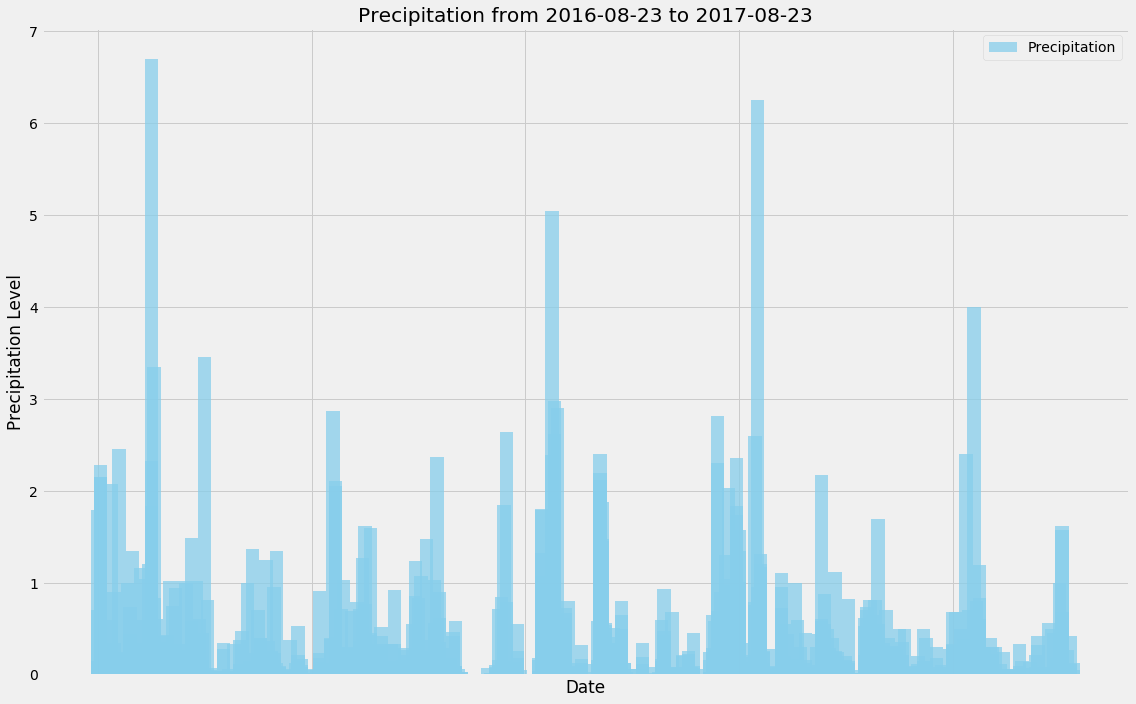

In [48]:
# Use Pandas Plotting with Matplotlib to plot the data
x_axis = prcp_df.index.tolist()
y_axis = prcp_df['precipitation'].tolist()

plt.figure(figsize=(16,10))
plt.bar(x_axis,y_axis,width=5 ,color='skyblue', alpha=0.75, align="center",label='Precipitation')
plt.tick_params(
    axis='x',          
    which='both',     
    bottom=False,      
    top=False,        
    labelbottom=False) 
major_ticks = np.arange(0,400,80)
plt.xticks(major_ticks)

plt.title(f"Precipitation from {query_date} to {last_date[0]}")
plt.xlabel("Date")
plt.ylabel("Precipitation Level")
plt.grid(which='major', axis='both', linestyle='-')
plt.legend()
plt.tight_layout()

plt.show()


In [50]:
# Use Pandas to calcualte the summary statistics for the precipitation data
prcp_df.describe()

,precipitation
count,2021.000000
mean,0.177279
std,0.461190
min,0.000000
25%,0.000000
50%,0.020000
75%,0.130000
max,6.700000


In [51]:
# Design a query to show how many stations are available in this dataset?
session.query(Station.id).count()

9

In [53]:
# What are the most active stations? (i.e. what stations have the most rows)?
# List the stations and the counts in descending order.
active_stations =  session.query(Measurement.station, func.count(Measurement.station)).\
                    group_by(Measurement.station).\
                    order_by(func.count(Measurement.station).desc()).all()
active_stations

[('USC00519281', 2772),
 ('USC00519397', 2724),
 ('USC00513117', 2709),
 ('USC00519523', 2669),
 ('USC00516128', 2612),
 ('USC00514830', 2202),
 ('USC00511918', 1979),
 ('USC00517948', 1372),
 ('USC00518838', 511)]

In [54]:
# Using the station id from the previous query, calculate the lowest temperature recorded, 
# highest temperature recorded, and average temperature of the most active station?
station_data = session.query(func.min(Measurement.tobs),func.max(Measurement.tobs),func.avg(Measurement.tobs)).\
filter(Measurement.station == 'USC00519281').all()
station_data

[(54.0, 85.0, 71.66378066378067)]

In [90]:
# Choose the station with the highest number of temperature observations.
# Query the last 12 months of temperature observation data for this station and plot the results as a histogram
USC00519281_data = session.query(Measurement.tobs).\
    filter(Measurement.station == active_stations[0][0]).\
    filter(Measurement.date >= query_date).all()
USC00519281_data[:10]

[(77.0),
 (77.0),
 (80.0),
 (80.0),
 (75.0),
 (73.0),
 (78.0),
 (77.0),
 (78.0),
 (80.0)]

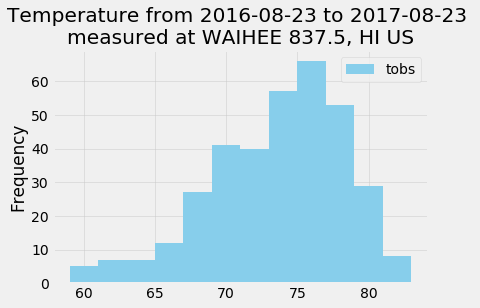

In [91]:
temperatures = list(np.ravel(USC00519281_data))
plt.hist(temperatures, bins=12,rwidth=1.0,label='tobs', color = 'skyblue')
plt.grid(axis='both', alpha=0.5)
plt.ylabel('Frequency')
plt.title(f'Temperature from {query_date} to {last_date[0]} \nmeasured at WAIHEE 837.5, HI US')
plt.legend()

plt.show()

## Bonus Challenge Assignment

In [92]:
# This function called `calc_temps` will accept start date and end date in the format '%Y-%m-%d' 
# and return the minimum, average, and maximum temperatures for that range of dates
def calc_temps(start_date, end_date):
    """TMIN, TAVG, and TMAX for a list of dates.
    
    Args:
        start_date (string): A date string in the format %Y-%m-%d
        end_date (string): A date string in the format %Y-%m-%d
        
    Returns:
        TMIN, TAVE, and TMAX
    """
    
    return session.query(func.min(Measurement.tobs), func.avg(Measurement.tobs), func.max(Measurement.tobs)).\
        filter(Measurement.date >= start_date).filter(Measurement.date <= end_date).all()

# function usage example
print(calc_temps('2012-02-28', '2012-03-05'))

[(62.0, 69.57142857142857, 74.0)]


In [101]:
# Use your previous function `calc_temps` to calculate the tmin, tavg, and tmax 
# for your trip using the previous year's data for those same dates.
trip_start = '2017-05-01'
trip_end = '2017-05-07'
temp_result = calc_temps(trip_start,trip_end)[0]
tmin, tavg, tmax = calc_temps(trip_start,trip_end)[0]
print(tmin, tavg, tmax)

65.0 75.675 80.0


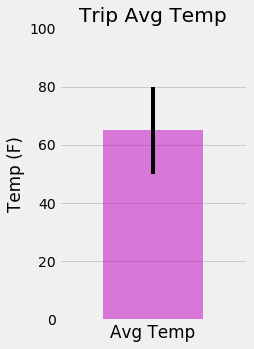

In [114]:
# Plot the results from your previous query as a bar chart. 
# Use "Trip Avg Temp" as your Title
# Use the average temperature for the y value
# Use the peak-to-peak (tmax-tmin) value as the y error bar (yerr)
x = [0]
y = [tmin]
error = [(tmax - tmin)]

plt.figure(figsize=(3,5))
plt.bar(x,y,yerr=error,color='m',alpha=.5,align='center')
plt.xlim(-0.75,0.75)
plt.ylim(0,100)
plt.tick_params(axis='x',which='both',bottom=False,top=False,labelbottom=False)
plt.grid(which='major', axis='x', linestyle='')
plt.xlabel("Avg Temp")
plt.ylabel("Temp (F)")
plt.title("Trip Avg Temp")

plt.show()

In [129]:
# Calculate the total amount of rainfall per weather station for your trip dates using the previous year's matching dates.
# Sort this in descending order by precipitation amount and list the station, name, latitude, longitude, and elevation

query_columns = [Station.station, Station.name, func.sum(Measurement.tobs), Station.latitude, Station.longitude, Station.elevation]

start_date = '2017-05-10'
end_date = '2017-05-22'

query_result = session.query(*query_columns).\
                    group_by(Measurement.station).\
                    outerjoin(Station, Measurement.station==Station.station).\
                    filter(Measurement.date >= start_date).filter(Measurement.date <= end_date).\
                    order_by(func.sum(Measurement.tobs).desc()).all()
query_result
rainfall_df = pd.DataFrame(query_result,
             columns=["Station","Station_Name", "Total_Rainfall", "Latitude", "Longitude", "Elevation"]
            ).sort_values("Total_Rainfall",ascending=False)
rainfall_df

,Station,Station_Name,Total_Rainfall,Latitude,Longitude,Elevation
0,USC00519397,"WAIKIKI 717.2, HI US",1005.0,21.27160,-157.81680,3.0
1,USC00513117,"KANEOHE 838.1, HI US",958.0,21.42340,-157.80150,14.6
2,USC00519281,"WAIHEE 837.5, HI US",952.0,21.45167,-157.84889,32.9
3,USC00519523,"WAIMANALO EXPERIMENTAL FARM, HI US",921.0,21.33556,-157.71139,19.5
4,USC00516128,"MANOA LYON ARBO 785.2, HI US",855.0,21.33310,-157.80250,152.4
5,USC00514830,"KUALOA RANCH HEADQUARTERS 886.9, HI US",701.0,21.52130,-157.83740,7.0


In [ ]:
# Create a query that will calculate the daily normals 
# (i.e. the averages for tmin, tmax, and tavg for all historic data matching a specific month and day)

def daily_normals(date):
    """Daily Normals.
    
    Args:
        date (str): A date string in the format '%m-%d'
        
    Returns:
        A list of tuples containing the daily normals, tmin, tavg, and tmax
    
    """
    
    sel = [func.min(Measurement.tobs), func.avg(Measurement.tobs), func.max(Measurement.tobs)]
    return session.query(*sel).filter(func.strftime("%m-%d", Measurement.date) == date).all()
    
daily_normals("01-01")

In [ ]:
# calculate the daily normals for your trip
# push each tuple of calculations into a list called `normals`

# Set the start and end date of the trip

# Use the start and end date to create a range of dates

# Stip off the year and save a list of %m-%d strings

# Loop through the list of %m-%d strings and calculate the normals for each date


In [ ]:
# Load the previous query results into a Pandas DataFrame and add the `trip_dates` range as the `date` index


In [ ]:
# Plot the daily normals as an area plot with `stacked=False`
